# Regression with Insurance Data: Predict insurance premiums based on various factors... by Anand CJ

# Start

# Set up: Huge data files uploaded as kaggle datasets and downloaded to read from google collab

In [6]:
# !pip install kaggle

In [7]:
# !rm -rf /root/.kaggle/kaggle.json

In [8]:
# import shutil
# import os

# # Create a Kaggle directory
# os.makedirs("/root/.kaggle", exist_ok=True)

# # Move kaggle.json to the directory
# shutil.move("/content/kaggle.json", "/root/.kaggle/")

# # Set permissions
# os.chmod("/root/.kaggle/kaggle.json", 600)

# print("Kaggle API key configured successfully!")

In [9]:
################################################################################
## Set the path using google collab note book to the dataset in kaggle  ##
################################################################################
!kaggle datasets download -d cjanand/pt-insurance-premium-dataset --unzip -p /content/data

Dataset URL: https://www.kaggle.com/datasets/cjanand/pt-insurance-premium-dataset
License(s): unknown
 84% 66.0M/78.3M [00:00<00:00, 98.5MB/s]
100% 78.3M/78.3M [00:00<00:00, 112MB/s] 


## Import Libraries

In [10]:
##########################################
## Import required python libraries ##
##########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score , classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.tree import plot_tree

## Import Data

In [11]:
############################################################
## Load Data into train, test and submission df ##
############################################################
train_df = pd.read_csv("/content/data/train.csv")
test_df = pd.read_csv("/content/data/test.csv")
sample_submission_df = pd.read_csv("/content/data/sample_submission.csv")

# Display first few rows
print(train_df.shape, test_df.shape, sample_submission_df.shape)

(1200000, 21) (800000, 20) (800000, 2)


# Data Pre-Processing, Exploratory Data Analysis

##Explore the Data

In [12]:
##################################################################################################
## Explore the Data. Understanding the structure and content of training and test datasets ##
##################################################################################################
print(set(train_df.columns) - set(test_df.columns))
print(' Train columns ', train_df.columns)
print(' Train shape ', train_df.shape)
print(' Train feature types ', train_df.dtypes)
print(' Test columns ', test_df.columns)
print(' Test shape ', test_df.shape)
print(' Test feature types ', test_df.dtypes)


{'Premium Amount'}
 Train columns  Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')
 Train shape  (1200000, 21)
 Train feature types  id                        int64
Age                     float64
Gender                   object
Annual Income           float64
Marital Status           object
Number of Dependents    float64
Education Level          object
Occupation               object
Health Score            float64
Location                 object
Policy Type              object
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date      

In [13]:
#################################################################################
## Explore the Data. # Distribution of all numerical features ##
#################################################################################
############ Histogram Plots to check on distributions ############
##### Numerical features ####
# Previous Claims
# Credit Score
# Number of Dependents
# Health Score
# Annual Income
# Age
# Vehicle Age
# Insurance Duration

# sns.histplot(train_df['Previous Claims'], bins=20, kde=True)
# plt.title('Histogram of Previous Claims')
# plt.show()

In [14]:
#################################################################################
## Explore the Data. # Frequency distribution of all categorical features ##
#################################################################################
# Count unique values for categorical columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns

print(categorical_cols)
for col in categorical_cols:
    print(f"{col} Distribution:\n{train_df[col].value_counts()}\n")


Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Policy Start Date', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type'],
      dtype='object')
Gender Distribution:
Gender
Male      602571
Female    597429
Name: count, dtype: int64

Marital Status Distribution:
Marital Status
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64

Education Level Distribution:
Education Level
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64

Occupation Distribution:
Occupation
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64

Location Distribution:
Location
Suburban    401542
Rural       400947
Urban       397511
Name: count, dtype: int64

Policy Type Distribution:
Policy Type
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64

Pol

In [15]:
#################################################################################
## Explore the Data. # Distribution of all categorical features by Plots ##
#################################################################################
##### Categorical features ####
# Occupation
# Customer Feedback
# Marital Status
# Gender
# Education Level
# Location
# Policy Type
# Exercise Frequency
# Property Type
# Smoking Status

############ Box Plots to check on distributions ############
# plt.figure(figsize=(10, 6))
# sns.boxplot(x=train_df['Smoking Status'], y=train_df['Premium Amount'])
# plt.title('Smoking Status vs Premium Amount')
# plt.xlabel('Smoking Status')
# plt.ylabel('Premium Amount')
# plt.xticks(rotation=45)  # Rotate labels if needed
# plt.show()

# ############ Scatter Plots to check on distributions ############
# plt.figure(figsize=(10, 6))
# plt.scatter(train_df['Smoking Status'], train_df['Premium Amount'])
# plt.title('Smoking Status vs Premium')
# plt.xlabel('Smoking Status')
# plt.ylabel('Premium')
# plt.show()

In [16]:
#########################################################################
## Explore the Data. # Compute skewness for all numerical features #
#########################################################################
# List of numerical columns to check
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
skew_values = train_df[numerical_cols].skew().sort_values(ascending=False)
print(skew_values.round(3))

# Set a threshold for transformation
threshold = 0.5  # Modify as needed

# Identify features needing transformation
skewed_features = skew_values[abs(skew_values) > threshold].index
print("Features requiring transformation:", skewed_features)

Annual Income           1.470
Premium Amount          1.241
Previous Claims         0.905
Health Score            0.282
id                      0.000
Insurance Duration     -0.009
Age                    -0.013
Number of Dependents   -0.013
Vehicle Age            -0.020
Credit Score           -0.114
dtype: float64
Features requiring transformation: Index(['Annual Income', 'Premium Amount', 'Previous Claims'], dtype='object')


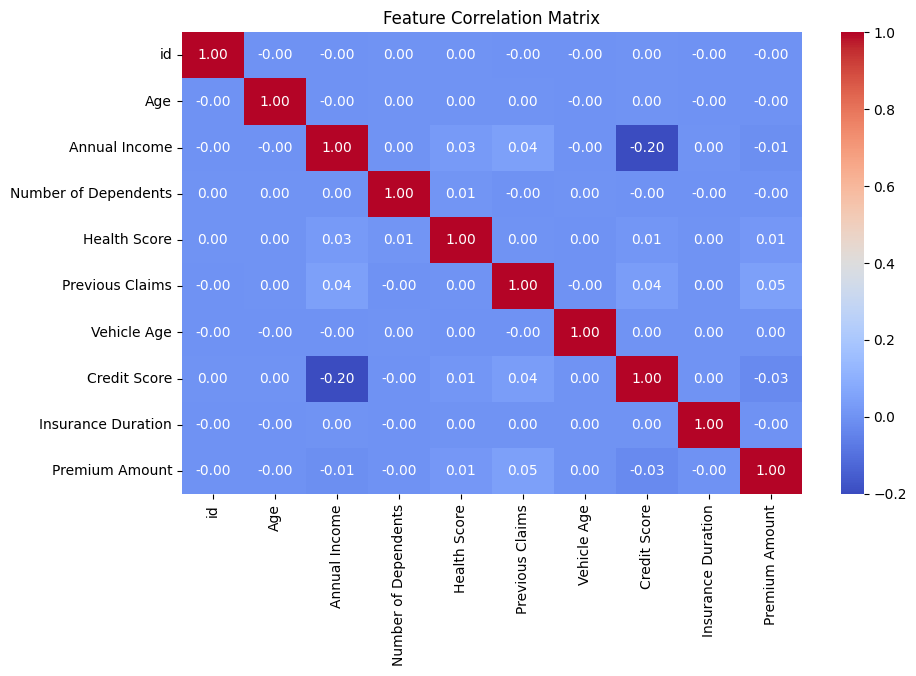

In [17]:
########################################################################################
## Explore the Data. # Compute Correlation for all numerical features with Target #
########################################################################################
# train_df.hist(bins=25, figsize=(20,15))
# plt.show()

# Select only numerical columns
numeric_cols = train_df.select_dtypes(include=['number'])
# Compute the correlation matrix
corr_matrix = numeric_cols.corr()
# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [18]:
#########################################################################################################
## Explore the Data. # Compute Chi-Square Test for Dependency of Categorical features with Target ##
#########################################################################################################
#Chi-Square for categorical features
from scipy.stats import chi2_contingency
# Count unique values for categorical columns
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns
categorical_cols

def chi_square_test_single(df, feature, target):
  import scipy.stats as stats
  contingency_table = pd.crosstab(df[feature], df[target])  # Create contingency table
  chi2, p, dof, expected = stats.chi2_contingency(contingency_table)  # Perform Chi-Square test

  if p < 0.05:
      significance = "Statisfically Significant"
  else:
      significance = "Not Statisfically Significant"
  return {"Feature": feature, "Chi2 Statistic": chi2, "P-value": p, "Result": significance}

##### Categorical features ####
# Gender
# Marital Status
# Education Level
# Occupation
# Location
# Policy Type
# Customer Feedback
# Smoking Status
# Exercise Frequency
# Property Type

resultchi = chi_square_test_single(train_df, 'Gender', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Marital Status', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Education Level', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Occupation', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Location', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Policy Type', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Customer Feedback', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Smoking Status', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Exercise Frequency', 'Premium Amount')
print(resultchi)

resultchi = chi_square_test_single(train_df, 'Property Type', 'Premium Amount')
print(resultchi)

{'Feature': 'Gender', 'Chi2 Statistic': 5400.10388126688, 'P-value': 1.2346445862590775e-09, 'Result': 'Statisfically Significant'}
{'Feature': 'Marital Status', 'Chi2 Statistic': 11296.302830564455, 'P-value': 6.054431134494578e-32, 'Result': 'Statisfically Significant'}
{'Feature': 'Education Level', 'Chi2 Statistic': 16260.40433429763, 'P-value': 8.882550062892367e-27, 'Result': 'Statisfically Significant'}
{'Feature': 'Occupation', 'Chi2 Statistic': 10791.407602234858, 'P-value': 8.606521113205207e-21, 'Result': 'Statisfically Significant'}
{'Feature': 'Location', 'Chi2 Statistic': 10675.228773641269, 'P-value': 1.5786637562714547e-14, 'Result': 'Statisfically Significant'}
{'Feature': 'Policy Type', 'Chi2 Statistic': 10543.957807989807, 'P-value': 1.0043336915411408e-11, 'Result': 'Statisfically Significant'}
{'Feature': 'Customer Feedback', 'Chi2 Statistic': 10950.525666241949, 'P-value': 3.130419632356064e-22, 'Result': 'Statisfically Significant'}
{'Feature': 'Smoking Status', 

In [19]:
###################################################################################################
## Explore the Data. Understanding missing values of training and test datasets ##
###################################################################################################
print(train_df.isnull().sum().sort_values(ascending = False))
print('======================')
print(test_df.isnull().sum().sort_values(ascending = False))

Previous Claims         364029
Occupation              358075
Credit Score            137882
Number of Dependents    109672
Customer Feedback        77824
Health Score             74076
Annual Income            44949
Age                      18705
Marital Status           18529
Vehicle Age                  6
Insurance Duration           1
id                           0
Property Type                0
Exercise Frequency           0
Smoking Status               0
Policy Type                  0
Policy Start Date            0
Location                     0
Education Level              0
Gender                       0
Premium Amount               0
dtype: int64
Previous Claims         242802
Occupation              239125
Credit Score             91451
Number of Dependents     73130
Customer Feedback        52276
Health Score             49449
Annual Income            29860
Age                      12489
Marital Status           12336
Vehicle Age                  3
Insurance Duration        

In [20]:
################################################################################
## Explore the Data. Understanding mean, median for numerical features ##
################################################################################
# Previous Claims
# Occupation
# Credit Score
# Number of Dependents
# Customer Feedback
# Health Score
# Annual Income
# Age
# Marital Status

## Replace any of the above numerical feature in the code below ##
# mean_value = train_df['Number of Dependents'].mean()
# median_value = train_df['Number of Dependents'].median()
# mode_value = train_df['Number of Dependents'].mode()
# print(f"Mean: {mean_value}, Median: {median_value}, Mode {mode_value}")

## Pre-Process the data

# Model development

## Build the XG Boost Model

In [21]:
##########################################################################################################
## X features, y target, Pipeline for model, Train the model, Prediction ##
##########################################################################################################

# Separate Features & Target
X = train_df.drop(columns=['Premium Amount', 'Policy Start Date', 'id', 'Property Type'])
y = train_df['Premium Amount']

# Split Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

#################################################################################
## Data Transformation of Numerical features based on Skewness ##
#################################################################################
# **Manual Transformation** - Apply square root transformation
X_train['Annual Income'] = np.log1p(X_train['Annual Income'])
X_train['Previous Claims'] = np.log1p(X_train['Previous Claims'])

X_val['Annual Income'] = np.log1p(X_val['Annual Income'])
X_val['Previous Claims'] = np.log1p(X_val['Previous Claims'])

################################################################################
## PreProcess the data. Imputing for both numerical and categorical features ##
################################################################################
median_impute_cols = ['Annual Income', 'Previous Claims']
mean_impute_cols = ['Credit Score', 'Health Score', 'Age']
mode_impute_num_cols = ['Number of Dependents']
mode_impute_cat_cols = ['Occupation', 'Customer Feedback', 'Marital Status']

# Apply Imputation
median_imputer = SimpleImputer(strategy='median')
mean_imputer = SimpleImputer(strategy='mean')
mode_imputer_num = SimpleImputer(strategy='most_frequent')
mode_imputer_cat = SimpleImputer(strategy='most_frequent')

X_train[median_impute_cols] = median_imputer.fit_transform(X_train[median_impute_cols])
X_val[median_impute_cols] = median_imputer.transform(X_val[median_impute_cols])
test_df[median_impute_cols] = median_imputer.transform(test_df[median_impute_cols])


X_train[mean_impute_cols] = mean_imputer.fit_transform(X_train[mean_impute_cols])
X_val[mean_impute_cols] = mean_imputer.transform(X_val[mean_impute_cols])
test_df[mean_impute_cols] = mean_imputer.transform(test_df[mean_impute_cols])

X_train[mode_impute_num_cols] = mode_imputer_num.fit_transform(X_train[mode_impute_num_cols])
X_val[mode_impute_num_cols] = mode_imputer_num.transform(X_val[mode_impute_num_cols])
test_df[mode_impute_num_cols] = mode_imputer_num.transform(test_df[mode_impute_num_cols])

X_train[mode_impute_cat_cols] = mode_imputer_cat.fit_transform(X_train[mode_impute_cat_cols])
X_val[mode_impute_cat_cols] = mode_imputer_cat.transform(X_val[mode_impute_cat_cols])
test_df[mode_impute_cat_cols] = mode_imputer_cat.transform(test_df[mode_impute_cat_cols])

#############################################################################################
## PreProcess the Data. Apply Encoding  to categorical features  ##
#############################################################################################

# Define Encoding Strategies
ordinal_encode_cols = ['Gender', 'Marital Status', 'Education Level', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency']
onehot_encode_cols = list(set(categorical_cols) - set(ordinal_encode_cols))

####### Encoding the columns with Ordinal encoding #######
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[ordinal_encode_cols] = ordinal_encoder.fit_transform(X_train[ordinal_encode_cols])
X_val[ordinal_encode_cols] = ordinal_encoder.transform(X_val[ordinal_encode_cols])
test_df[ordinal_encode_cols] = ordinal_encoder.transform(test_df[ordinal_encode_cols])
####### Encoding the columns with One hot encoding  #######
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_ohe = pd.DataFrame(onehot_encoder.fit_transform(X_train[onehot_encode_cols]))
X_val_ohe = pd.DataFrame(onehot_encoder.transform(X_val[onehot_encode_cols]))
test_df_ohe = pd.DataFrame(onehot_encoder.transform(test_df[onehot_encode_cols]))
# Add back column names after One-Hot Encoding
X_train_ohe.columns = onehot_encoder.get_feature_names_out(onehot_encode_cols)
X_val_ohe.columns = onehot_encoder.get_feature_names_out(onehot_encode_cols)
test_df_ohe.columns = onehot_encoder.get_feature_names_out(onehot_encode_cols)
# Drop original categorical columns and concatenate One-Hot Encoded data
X_train = X_train.drop(columns=onehot_encode_cols).reset_index(drop=True)
X_val = X_val.drop(columns=onehot_encode_cols).reset_index(drop=True)
test_df = test_df.drop(columns=onehot_encode_cols).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_val = pd.concat([X_val, X_val_ohe], axis=1)
test_df = pd.concat([test_df, test_df_ohe], axis=1)
#############################################################################################
## PreProcess the Data. Apply Scaling to numerical features  ##
#############################################################################################

# Define Scaling Strategies
minmax_scale_cols = ['Credit Score', 'Vehicle Age', 'Age']
standard_scale_cols = ['Health Score']

# Apply Min-Max Scaling
minmax_scaler = MinMaxScaler()
X_train[minmax_scale_cols] = minmax_scaler.fit_transform(X_train[minmax_scale_cols])
X_val[minmax_scale_cols] = minmax_scaler.transform(X_val[minmax_scale_cols])
test_df[minmax_scale_cols] = minmax_scaler.transform(test_df[minmax_scale_cols])

# Apply Standard Scaling
standard_scaler = StandardScaler()
X_train[standard_scale_cols] = standard_scaler.fit_transform(X_train[standard_scale_cols])
X_val[standard_scale_cols] = standard_scaler.transform(X_val[standard_scale_cols])
test_df[standard_scale_cols] = standard_scaler.transform(test_df[standard_scale_cols])
# No scaling applied to 'Number of Dependents' and 'Insurance Duration'

# Display scaled dataset
# train_df.loc[:,['Credit Score','Credit__Score','Vehicle Age','Vehicle__Age', 'Health Score','Health__Score','Age', 'Age__']].head()

# sns.histplot(train_df['Health Score'], bins=20, kde=True)
# plt.title('Histogram of Health Score')
# plt.show()

## Train, Predict and Evaluate XG Booost Model

In [22]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((900000, 23), (900000,), (300000, 23), (300000,))

In [23]:
# Train Random Forest Model
%%time
from xgboost import XGBRegressor
# Define XGBoost Model with Tuned Hyperparameters
xgb_model = XGBRegressor(
    n_estimators=1000,  # Increased number of trees
    learning_rate=0.01,  # Reduced learning rate for stability
    max_depth=10,  # Slightly deeper trees
    subsample=0.8,  # Use 80% of data per tree
    colsample_bytree=0.75,  # Use 70% of features per tree
    reg_lambda=2.0,  # L2 Regularization
    reg_alpha=1.0,  # L1 Regularization
    random_state=42,
    n_jobs=-1
)

# X_train_sample = X_train.sample(frac=0.1, random_state=42)   # Sample of Training Data for Faster Training
# y_train_sample = y_train.iloc[X_train_sample.index]  # Match indices

# Select Top Features Based on Feature Importance
selected_features = [
    "Previous Claims", "Annual Income", "Health Score", "Customer Feedback",
    "Credit Score", "Occupation_Employed", "Vehicle Age", "Insurance Duration",
    "Exercise Frequency", "Policy Type_Premium", "Age",
    "Number of Dependents", "Marital Status", "Education Level",
    "Location_Urban", "Location_Suburban", "Location_Rural"
]

#Filter Features
# X_train_filtered = X_train[selected_features]
# X_val_filtered = X_val[selected_features]

X_train_filtered = X_train[selected_features].copy()
X_val_filtered = X_val[selected_features].copy()
test_df_filtered = test_df[selected_features].copy()

# Feature Engineering
X_train_filtered["Income_Credit_Score"] = X_train_filtered["Annual Income"] * X_train_filtered["Credit Score"]
X_val_filtered["Income_Credit_Score"] = X_val_filtered["Annual Income"] * X_val_filtered["Credit Score"]
test_df_filtered["Income_Credit_Score"] = test_df_filtered["Annual Income"] * test_df_filtered["Credit Score"]

X_train_filtered["Age_Claims"] = X_train_filtered["Age"] * X_train_filtered["Previous Claims"]
X_val_filtered["Age_Claims"] = X_val_filtered["Age"] * X_val_filtered["Previous Claims"]
test_df_filtered["Age_Claims"] = test_df_filtered["Age"] * test_df_filtered["Previous Claims"]

X_train_filtered["log_Annual_Income"] = np.log1p(X_train_filtered["Annual Income"])
X_val_filtered["log_Annual_Income"] = np.log1p(X_val_filtered["Annual Income"])
test_df_filtered["log_Annual_Income"] = np.log1p(test_df_filtered["Annual Income"])

X_train_filtered["Income_Per_Dependent"] = X_train_filtered["Annual Income"] / (X_train_filtered["Number of Dependents"] + 1)
X_val_filtered["Income_Per_Dependent"] = X_val_filtered["Annual Income"] / (X_val_filtered["Number of Dependents"] + 1)
test_df_filtered["Income_Per_Dependent"] = test_df_filtered["Annual Income"] / (test_df_filtered["Number of Dependents"] + 1)

X_train_filtered["Health_Credit"] = X_train_filtered["Health Score"] * X_train_filtered["Credit Score"]
X_val_filtered["Health_Credit"] = X_val_filtered["Health Score"] * X_val_filtered["Credit Score"]
test_df_filtered["Health_Credit"] = test_df_filtered["Health Score"] * test_df_filtered["Credit Score"]

X_train_filtered["log_Previous Claims"] = np.log1p(X_train_filtered["Previous Claims"])
X_val_filtered["log_Previous Claims"] = np.log1p(X_val_filtered["Previous Claims"])
test_df_filtered["log_Previous Claims"] = np.log1p(test_df_filtered["Previous Claims"])


# X_train_filtered["Age_Group"] = pd.cut(X_train_filtered["Age"], bins=[18, 30, 45, 60, 100], labels=[1, 2, 3, 4])
# X_val_filtered["Age_Group"] = pd.cut(X_val_filtered["Age"], bins=[18, 30, 45, 60, 100], labels=[1, 2, 3, 4])

# Train Model
# rfmodel.fit(X_train_filtered, y_train_sample)
xgb_model.fit(X_train_filtered, y_train)

# Predictions
y_train_pred = xgb_model.predict(X_train_filtered)
y_val_pred = xgb_model.predict(X_val_filtered)

# Compute Metrics
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_val, y_val_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
valid_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Print Metrics
print(f"Train R2 Score: {train_r2:.4f}")
print(f"Validation R2 Score: {valid_r2:.4f}")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {valid_rmse:.4f}")

Train R2 Score: 0.1239
Validation R2 Score: 0.0416
Train RMSE: 809.4709
Validation RMSE: 847.3993
CPU times: user 9min 19s, sys: 1.71 s, total: 9min 21s
Wall time: 5min 18s


## XG Booost Model performance

## XG Booost model - Feature Importances

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.483211 to fit


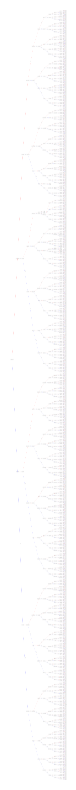

In [24]:
### Visualizing an Individual Tree from XGBoost
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Visualizing a single tree (tree index 0)
plt.figure(figsize=(20, 10))
plot_tree(xgb_model, num_trees=0, rankdir='LR', ax=plt.gca())  # Change num_trees to explore different trees
plt.show()

log_Previous Claims     0.111174
log_Annual_Income       0.077788
Annual Income           0.066791
Health_Credit           0.056744
Health Score            0.056259
Customer Feedback       0.052207
Income_Credit_Score     0.048774
Previous Claims         0.046858
Credit Score            0.046682
Age_Claims              0.038166
Income_Per_Dependent    0.036353
Age                     0.033996
Marital Status          0.031581
Vehicle Age             0.030920
Location_Rural          0.030886
Education Level         0.030493
Location_Suburban       0.030264
Insurance Duration      0.030211
Location_Urban          0.029583
Exercise Frequency      0.029230
Policy Type_Premium     0.028891
Occupation_Employed     0.028138
Number of Dependents    0.028010
dtype: float32


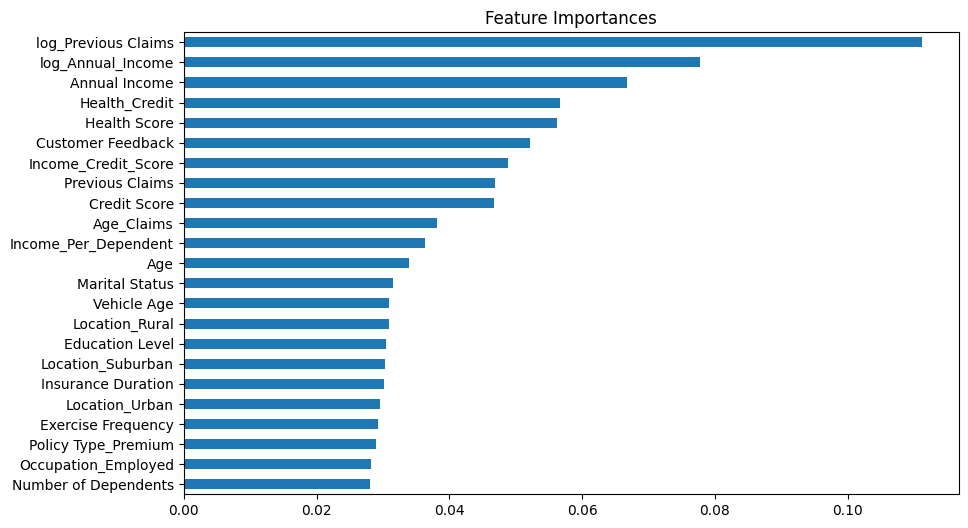

In [25]:
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train_filtered.columns).sort_values(ascending=True)
print(feature_importances.sort_values(ascending=False))
feature_importances.plot(kind='barh', figsize=(10, 6))
plt.title("Feature Importances")
plt.show()

# Test and Validation

In [26]:
# Ensure test data contains only selected features
# Make predictions
y_test_pred = xgb_model.predict(test_df_filtered)

# Convert predictions to DataFrame (optional)
test_predictions = pd.DataFrame({'Predicted_Premium': y_test_pred})

# Display first few predictions
print(test_predictions.head())



   Predicted_Premium
0         854.039612
1        1119.584106
2        1166.938965
3         511.663788
4         682.875427


# Prepare and Save submission file

In [27]:
# Save Submission File
sample_submission_df['Premium Amount'] = y_test_pred # second column for predicted target values
sample_submission_df.to_csv('submission_xgb.csv', index=False)
print("Submission file saved as 'submission_xgb.csv'")

# # Save predictions to CSV (optional)
# test_predictions.to_csv("test_predictions.csv", index=False)
# print("Predictions saved to test_predictions.csv")

Submission file saved as 'submission_xgb.csv'


In [28]:
## Train and Save the XGBoost Model
import joblib
# Save the model
joblib.dump(xgb_model, "xgboost_model.pkl")

['xgboost_model.pkl']

# Finish